In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from sklearn import preprocessing
import requests
import pickle
from io import BytesIO

In [2]:
def scrop(img, rdim=None):
    """square center crop"""
    cdim = min([img.width, img.height])
    width, height = img.size
    
    left =   (width  - cdim)/2
    top =    (height - cdim)/2
    right =  (width  + cdim)/2
    bottom = (height + cdim)/2
    
    if rdim:
        return img.crop((left, top, right, bottom)).resize((rdim, rdim))
    else:
        return img.crop((left, top, right, bottom))

def url_imread(url, asaray=False):
    response = requests.get(url)
    if asaray:
        return np.asarray(Image.open(BytesIO(response.content)))
    else:
        return Image.open(BytesIO(response.content))

def imshows(imgs, labels=None, scale=10):
    n = len(imgs)
    fig, axs = plt.subplots(nrows=1, ncols=n, figsize=(scale*n, scale))
    for i in range(n):
        axs[i].imshow(imgs[i])
        if labels:
            axs[i].title(labels[i])
    plt.show()

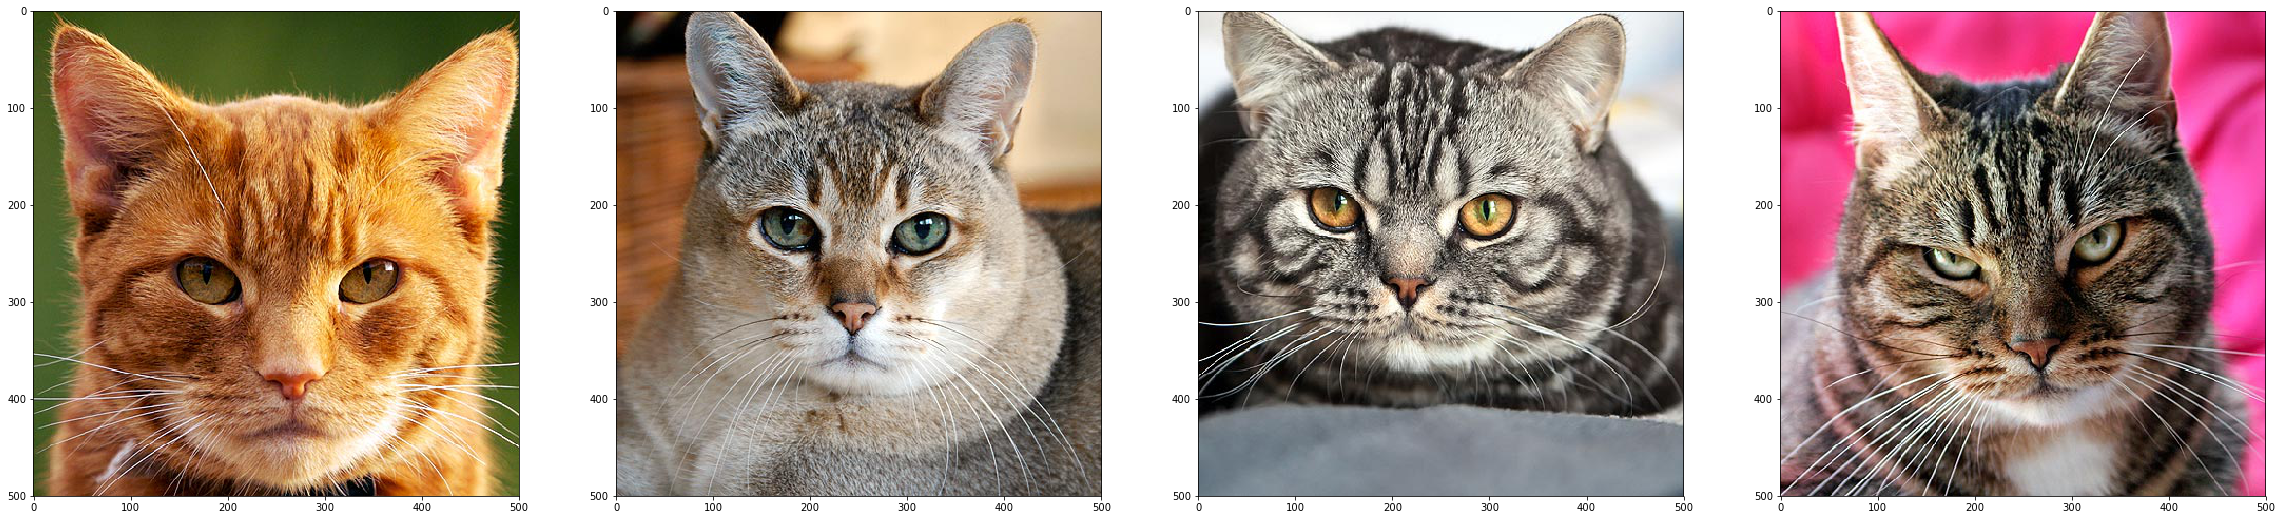

In [3]:
urls = [
    'https://www.petfinder.com/wp-content/uploads/2012/11/140272627-grooming-needs-senior-cat-632x475.jpg',
    'https://www.petfinder.com/wp-content/uploads/2012/11/91615172-find-a-lump-on-cats-skin-632x475.jpg',
    'https://www.petfinder.com/wp-content/uploads/2012/11/152964589-welcome-home-new-cat-632x475.jpg',
    'https://www.petfinder.com/wp-content/uploads/2012/11/99233806-bringing-home-new-cat-632x475.jpg',
]

cats = np.stack([np.asarray(scrop(url_imread(url), rdim=500)) for url in urls])
imshows(cats)

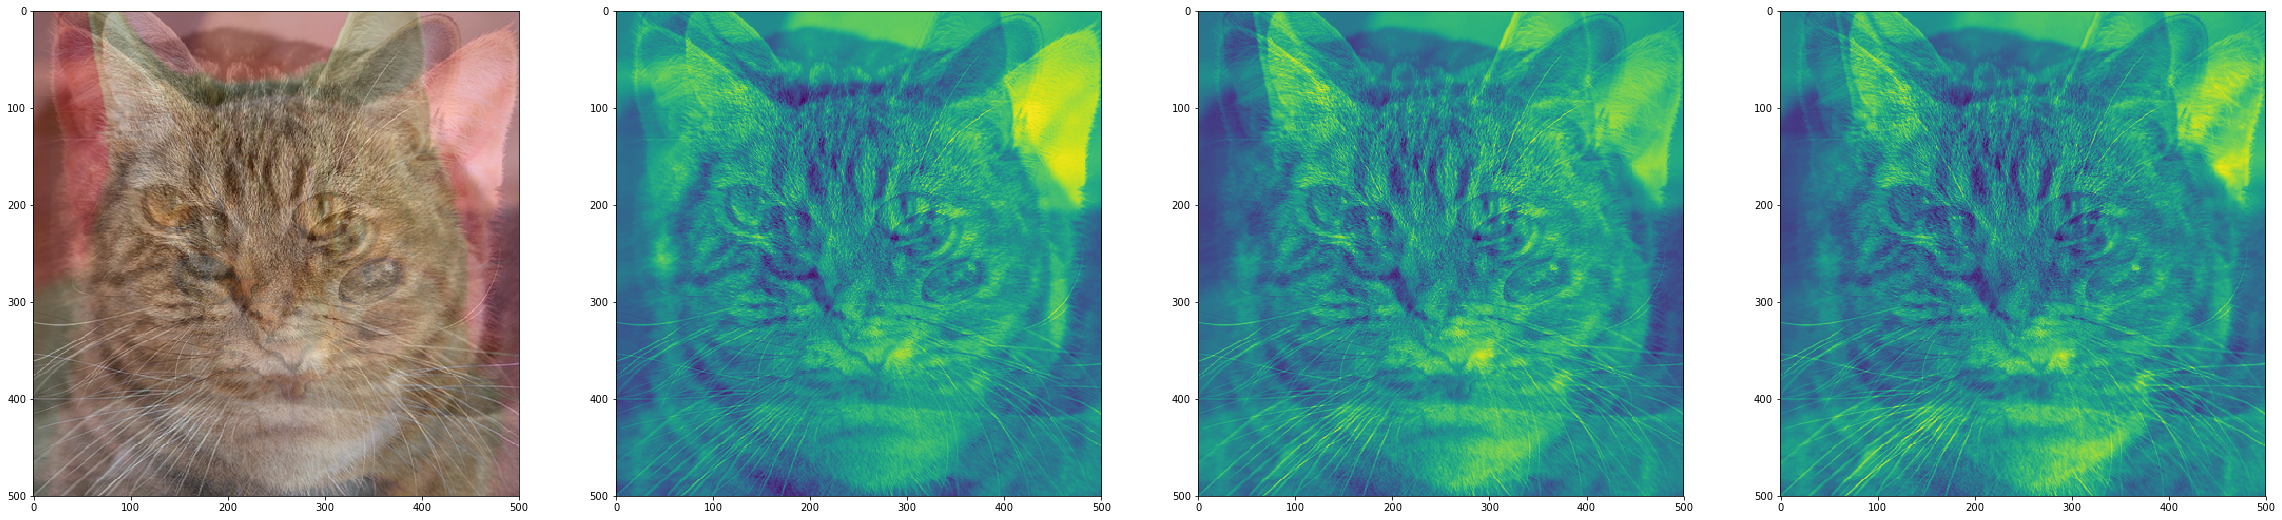

In [4]:
mean = np.mean(cats, axis=0).astype('uint8')
imshows([mean] + [mean[:,:,i] for i in range(3)])

In [3]:
data = pickle.load(file('around_83_subjects.pickle'))
data.head() # every 64 rows is a trial/participant

category  seed                                             latent  \
0  fire hydrant     9  [0.318729756113, 0.0570832261575, 0.9475105962...   
1  fire hydrant     9  [0.318729756113, 0.0570832261575, 0.9475105962...   
2        person    11  [-0.706095522455, 0.440705056055, 0.5848716333...   
3           car     5  [-0.891658442333, -0.32385145553, -0.287652180...   
4  fire hydrant    14  [-0.299452836379, -0.672043507883, 0.662542490...   

   node_id                                              image chosen  
0        2  https://dlgr-deep.s3.amazonaws.com/ab060b5e-b3...   True  
1        3  https://dlgr-deep.s3.amazonaws.com/ab060b5e-b3...   True  
2        4  https://dlgr-deep.s3.amazonaws.com/e9b7df33-6b...   True  
3        5  https://dlgr-deep.s3.amazonaws.com/5cbe72d4-bf...   True  
4        6  https://dlgr-deep.s3.amazonaws.com/2b67d538-c0...   True

In [4]:
encoder = preprocessing.LabelEncoder()
data['label'] = encoder.fit_transform(data.category)
data.head()

category  seed                                             latent  \
0  fire hydrant     9  [0.318729756113, 0.0570832261575, 0.9475105962...   
1  fire hydrant     9  [0.318729756113, 0.0570832261575, 0.9475105962...   
2        person    11  [-0.706095522455, 0.440705056055, 0.5848716333...   
3           car     5  [-0.891658442333, -0.32385145553, -0.287652180...   
4  fire hydrant    14  [-0.299452836379, -0.672043507883, 0.662542490...   

   node_id                                              image chosen  label  
0        2  https://dlgr-deep.s3.amazonaws.com/ab060b5e-b3...   True      2  
1        3  https://dlgr-deep.s3.amazonaws.com/ab060b5e-b3...   True      2  
2        4  https://dlgr-deep.s3.amazonaws.com/e9b7df33-6b...   True      3  
3        5  https://dlgr-deep.s3.amazonaws.com/5cbe72d4-bf...   True      1  
4        6  https://dlgr-deep.s3.amazonaws.com/2b67d538-c0...   True      2

In [124]:
categories = list(set(data.category))
categories

[u'person', u'fire hydrant', u'television', u'bottle', u'car']

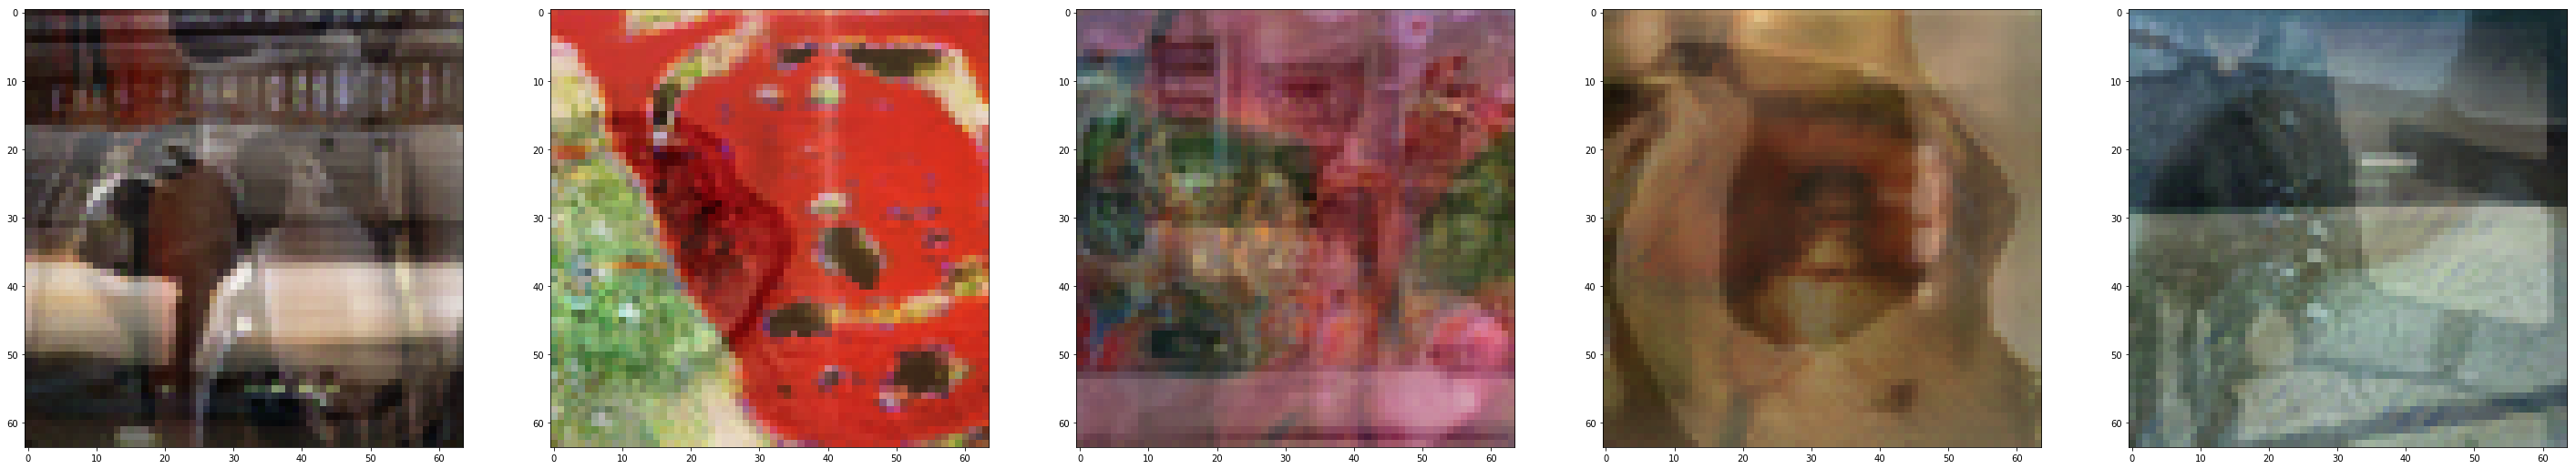

In [44]:
means = {}
for c in categories:
    stack = np.stack([url_imread(url) for url in data[data.category == c].image])
    means[c] = np.mean(stack, axis=0).astype('uint8')

np.savez('means.npz', **means) # dict(np.load('means.npz'))
imshows(means.values())

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

X = np.stack(data.latent)
y = np.asarray(data.label)

In [6]:
X_pca = PCA(n_components=2).fit_transform(X, y)
X_lda = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
# X_tsne = TSNE(n_components=2).fit_transform(X, y)

```Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Vega10, Vega10_r, Vega20, Vega20_r, Vega20b, Vega20b_r, Vega20c, Vega20c_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r```

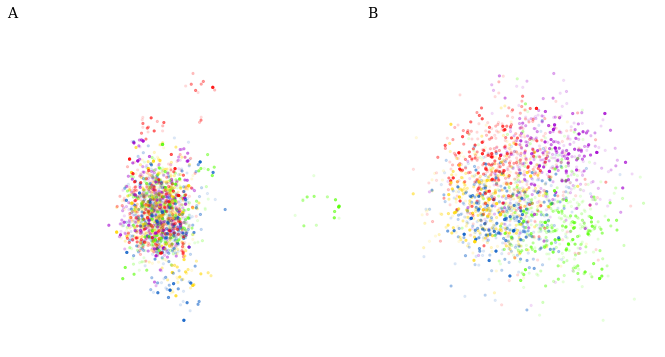

In [123]:
import matplotlib.cm as cm

csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}
sfont = {'fontname':'serif'}
cmap = 'prism'

scale = 5
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=[2*scale, scale])

axs[0].scatter(X_pca[:,0], X_pca[:,1], s=5, c=y, alpha=0.1, cmap=cmap)
# axs[0].set_title('PCA', **sfont)
axs[0].axis('off')

axs[1].scatter(X_lda[:,0], X_lda[:,1], s=5, c=y, alpha=0.1, cmap=cmap)
# axs[1].set_title('LDA', **sfont)
axs[1].axis('off')

fig.text(0.0, 1.0, 'A', fontsize=14, **sfont)
fig.text(0.5, 1.0, 'B', fontsize=14, **sfont)

# plt.savefig('out.pdf')

In [178]:
ax.axis?

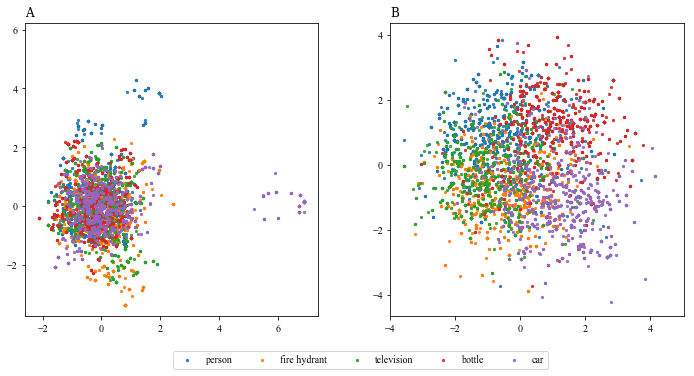

In [191]:
import matplotlib
matplotlib.rc('font',family='Times New Roman')

fig = plt.figure(figsize=[12,6])

ax = plt.subplot(121)
for z in set(data.label):
    ax.scatter(X_pca[y==z][:,0], X_pca[y==z][:,1], s=5, alpha=0.9, label=categories[z])
    
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.set_title('A', loc='left', **sfont)
ax.axis('square')

ax = plt.subplot(122)
for z in set(data.label):
    ax.scatter(X_lda[y==z][:,0], X_lda[y==z][:,1], s=5, alpha=0.9, label=categories[z])
ax.set_title('B', loc='left', **sfont)
ax.axis('square')
    
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.1), ncol=5)

plt.savefig('pca-lda.pdf')

plt.show()

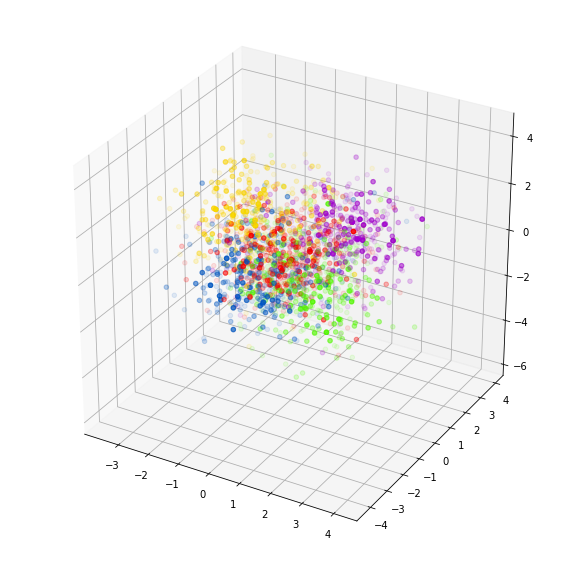

In [97]:
from mpl_toolkits.mplot3d import Axes3D

X_3d = LinearDiscriminantAnalysis(n_components=3).fit_transform(X, y)
# X_3d = PCA(n_components=3).fit_transform(X, y)

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3d[:,0], X_3d[:,1], X_3d[:,2], c=y, alpha=0.1, cmap=cmap)

In [246]:
full = pickle.load(file('around_83_subjects_full.pickle'))
full.tail(10)

category  seed                                             latent  \
10363        bottle    13  [-0.501325881435, -0.331035779205, 0.491420948...   
10364        bottle    13  [-0.455488939846, -0.277286202807, 0.546998412...   
10340  fire hydrant    14  [0.390681869527, 0.290748821121, -0.3617703399...   
10339  fire hydrant    14  [0.330458430293, 0.316967519223, -0.4405937948...   
10478        bottle    13  [-0.455488939846, -0.277286202807, 0.546998412...   
10477        bottle    13  [-0.521689000996, -0.276400324554, 0.507132479...   
10316    television    12  [0.227898047441, 0.37273138318, 0.49650561641,...   
10317    television    12  [0.214586532752, 0.369431170386, 0.43189803819...   
10495           car     5  [-0.240636590712, -0.232077756044, 0.758441688...   
10496           car     5  [0.118545517778, 0.35520441535, -0.14492548824...   

       node_id                                              image chosen  
10363     5865  https://dlgr-deep.s3.amazonaws.com/e3838a11-b3...  False  
10364     5865  https://dlgr-deep.s3.amazonaws.com/0babdad1-8e...   True  
10340     5866  https://dlgr-deep.s3.amazonaws.com/2eebe279-cf...   True  
10339     5866  https://dlgr-deep.s3.amazonaws.com/2d6a3e22-96...  False  
10478     5867  https://dlgr-deep.s3.amazonaws.com/0babdad1-8e...   True  
10477     5867  https://dlgr-deep.s3.amazonaws.com/15c2ae91-57...  False  
10316     5868  https://dlgr-deep.s3.amazonaws.com/75dc47dd-86...  False  
10317     5868  https://dlgr-deep.s3.amazonaws.com/54b1041b-bb...   True  
10495     5869  https://dlgr-deep.s3.amazonaws.com/141b558d-35...  False  
10496     5869  https://dlgr-deep.s3.amazonaws.com/4fbac585-3b...   True

In [282]:
# ignore row 0 because it is a source node
tups = [tuple(z) for z in full.latent][1:]
latent = list(full.latent)[1:]
chosen = list(full.chosen)[1:]

In [260]:
# the second is ALWAYS the proposal
acceptance_rates = [np.mean(chosen[i:i+64][1::2]) for i in range(0, (len(chosen)/64)*64, 64)]
acceptance_rates

[0.78125,
 0.8125,
 0.65625,
 0.6875,
 0.71875,
 0.5,
 0.5,
 0.6875,
 0.625,
 0.625,
 0.6875,
 0.53125,
 0.375,
 0.46875,
 0.53125,
 0.625,
 0.5,
 0.53125,
 0.34375,
 0.625,
 0.4375,
 0.4375,
 0.5,
 0.5625,
 0.4375,
 0.40625,
 0.40625,
 0.53125,
 0.4375,
 0.4375,
 0.625,
 0.46875,
 0.53125,
 0.53125,
 0.59375,
 0.4375,
 0.4375,
 0.75,
 0.46875,
 0.46875,
 0.375,
 0.59375,
 0.625,
 0.5,
 0.5,
 0.65625,
 0.46875,
 0.375,
 0.4375,
 0.59375,
 0.5625,
 0.5,
 0.5625,
 0.25,
 0.53125,
 0.53125,
 0.40625,
 0.5,
 0.5,
 0.46875,
 0.5,
 0.53125,
 0.625,
 0.53125,
 0.46875,
 0.53125,
 0.375,
 0.40625,
 0.5625,
 0.59375,
 0.625,
 0.5,
 0.5,
 0.5625,
 0.4375,
 0.53125,
 0.65625,
 0.46875,
 0.25,
 0.46875,
 0.40625,
 0.59375,
 0.40625,
 0.46875,
 0.625,
 0.46875,
 0.5625,
 0.5,
 0.5,
 0.5,
 0.4375,
 0.375,
 0.4375,
 0.5,
 0.59375,
 0.40625,
 0.53125,
 0.65625,
 0.5,
 0.59375,
 0.53125,
 0.53125,
 0.6875,
 0.75,
 0.46875,
 0.40625,
 0.5,
 0.625,
 0.59375,
 0.375,
 0.5625,
 0.40625,
 0.5625,
 0.40625,


In [261]:
# Overall acceptance rate
np.mean(acceptance_rates)

0.52000762195121952

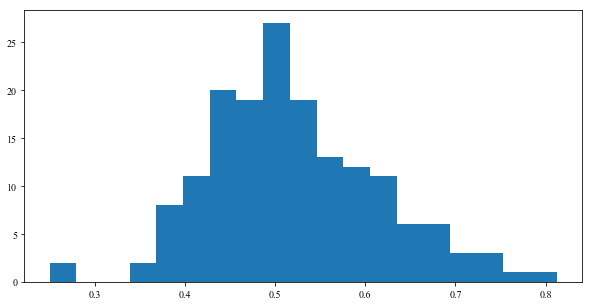

In [277]:
plt.figure(figsize=(10,5))
plt.hist(acceptance_rates, bins=19)
plt.savefig('hist.pdf')

In [297]:
X = np.asarray([np.linalg.norm(latent[i]-latent[i+1]) for i in range(0, (len(chosen)/64)*64, 2)])
y = np.asarray(chosen[1::2]).astype(int)

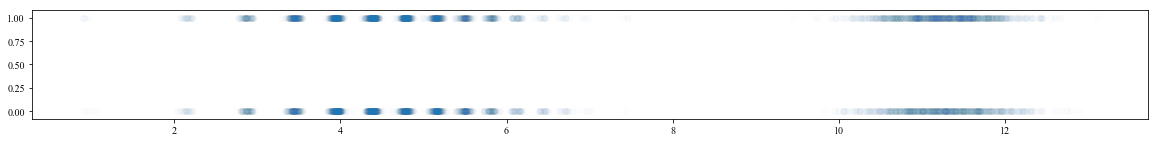

In [335]:
plt.figure(figsize=[20, 2])
plt.scatter(X, y, alpha=0.01)

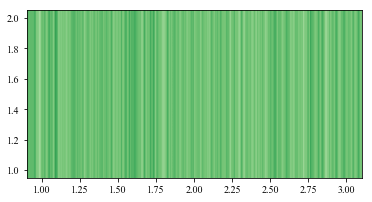

In [356]:
plt.imshow(np.tile(sorted(X, 100).reshape(100, X.shape[0]),
           cmap=mplt.cm.Greens, interpolation='bicubic', extent=plotlim)  

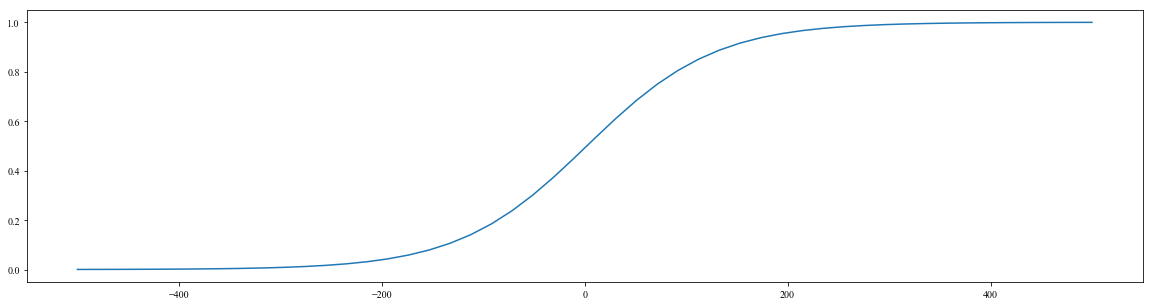

In [342]:
from sklearn.linear_model import LogisticRegression
from scipy.special import expit

clf = LogisticRegression()
clf.fit(X.reshape([X.shape[0], 1]), y)

plt.figure(figsize=[20, 5])
linspace = np.linspace(-500, 500, 50)
plt.plot(linspace, expit(clf.decision_function(linspace.reshape([50, 1]))))

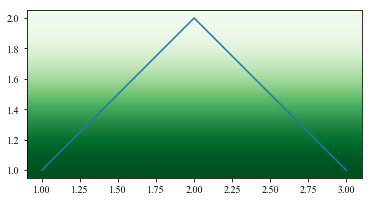

In [345]:
import matplotlib.pyplot as mplt  
fig = mplt.figure()  
ax = fig.add_subplot(111)  
mplt.plot([1,2,3],[1,2,1])  
plotlim = mplt.xlim() + mplt.ylim()  
ax.imshow([[0,0],[1,1]], cmap=mplt.cm.Greens, interpolation='bicubic', extent=plotlim)  
mplt.draw() 

/Users/alexyku/anaconda3/envs/python2/lib/python2.7/site-packages/skimage/measure/_marching_cubes_lewiner.py:167: skimage_deprecation: `marching_cubes` now uses a better and faster algorithm, and returns four instead of two outputs (see docstring for details). Backwards compatibility with 0.12 and prior is available with `marching_cubes_classic`. This function will be removed in 0.14, consider switching to `marching_cubes_lewiner`.
  warn(skimage_deprecation('`marching_cubes` now uses a better and '


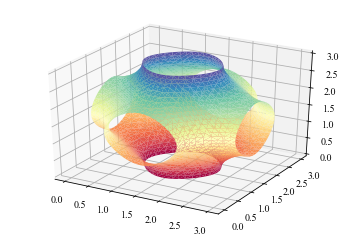

In [206]:
import numpy as np
from numpy import sin, cos, pi
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(f):
    x, y, z = pi*np.mgrid[-1:1:31j, -1:1:31j, -1:1:31j]
    vol = f(x, y, z)
    verts, faces = measure.marching_cubes(vol, 0, spacing=(0.1, 0.1, 0.1))[:2]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:,2],
                    cmap='Spectral', lw=1)
    plt.show()

# def fun(x, y, z):
#     return cos(x) + cos(y) + cos(z)

def fun(x, y, z):
    return cos(x) + cos(y) + cos(z)

plot3d(fun)

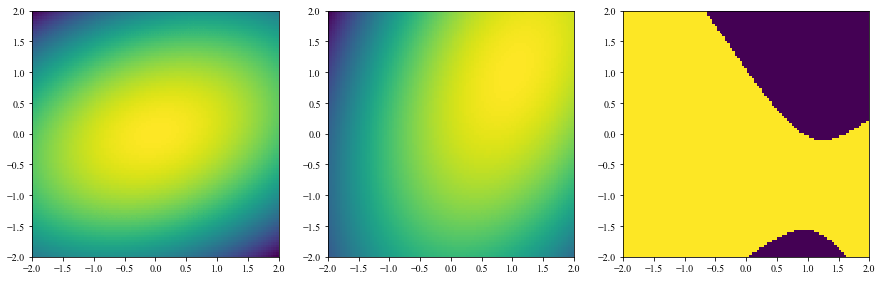

In [204]:
# http://stackoverflow.com/questions/22340808/plotting-a-discriminant-function-for-normal-densities-via-matplotlib

import pylab as pl
import numpy as np

D = 2

M1 = np.array([0.0, 0.0])
M2 = np.array([1.0, 1.0])

C1 = np.array([[2.0, 0.4], [0.4, 1.0]])
C2 = np.array([[1.0, 0.6], [0.6, 2.0]])

X, Y = np.mgrid[-2:2:100j, -2:2:100j]
points = np.c_[X.ravel(), Y.ravel()]

invC = np.linalg.inv(C1)
v = points - M1
g1 = -0.5*np.sum(np.dot(v, invC) * v, axis=1) - D*0.5*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(C1))
g1.shape = 100, 100

invC = np.linalg.inv(C2)
v = points - M2
g2 = -0.5*np.sum(np.dot(v, invC) * v, axis=1) - D*0.5*np.log(2*np.pi) - 0.5*np.log(np.linalg.det(C2))
g2.shape = 100, 100

fig, axes = pl.subplots(1, 3, figsize=(15, 5))
ax1, ax2, ax3 = axes.ravel()
for ax in axes.ravel():
    ax.set_aspect("equal")

ax1.pcolormesh(X, Y, g1)
ax2.pcolormesh(X, Y, g2)
ax3.pcolormesh(X, Y, g1 > g2)

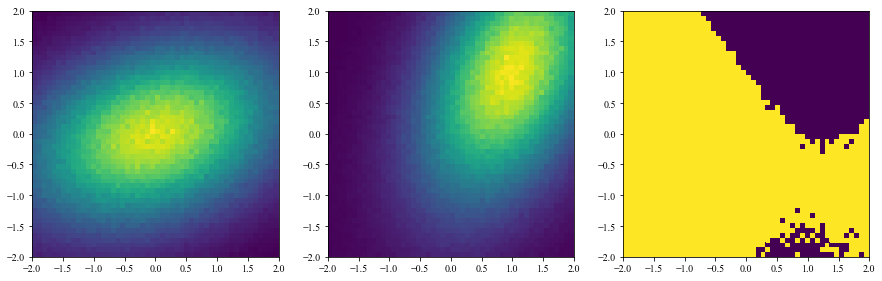

In [205]:
N = 3000000
r1 = np.random.multivariate_normal(M1, C1, N)
r2 = np.random.multivariate_normal(M2, C2, N)

h1, rx, ry = np.histogram2d(r1[:, 0], r1[:, 1], bins=50, range=[[-2, 2], [-2, 2]])
h2, _, _ = np.histogram2d(r2[:, 0], r2[:, 1], bins=50, range=[[-2, 2], [-2, 2]])

rx, ry = np.broadcast_arrays(rx[:, None], ry[None, :])

fig, axes = pl.subplots(1, 3, figsize=(15, 5))
ax1, ax2, ax3 = axes.ravel()
for ax in axes.ravel():
    ax.set_aspect("equal")

ax1.pcolormesh(rx, ry, h1)
ax2.pcolormesh(rx, ry, h2)
ax3.pcolormesh(rx, ry, h1 > h2)